In [1]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import euler_number
import porespy as ps
import matplotlib.pyplot as plt
import os
import numpy as np
import openpnm as op
import openpnm.models as mods
from openpnm.models import physics as pm
import pandas as pd

np.random.seed(0)

def n2_cal(pore_index,pore_occ):
    # cal of redundant loop
    return (pore_occ[pore_index[0]] & 
            pore_occ[pore_index[1]])

def n3_cal(pore_index,pore_occ):
    # cal of isolated pore
    return not (pore_occ[pore_index[0]] | 
            pore_occ[pore_index[1]])

# PATH = r'C:\Users\rtopa\OneDrive\phd22\gan\pnm\openpnm'
# PATH = r'C:\Users\rtopa\OneDrive\phd22\pnm\openpnm'
# os.chdir(PATH)
# im = np.load('1.npy')
raw_file = np.fromfile('Berea_2d25um_binary.raw', dtype=np.uint8)
im = (raw_file.reshape(1000,1000,1000))



# running snow algorithm to extract pore geometry information from network
snow = ps.networks.snow(
    im=im,
    voxel_size=2.32e-06)

# extracting network and geometry from snow simulation results
proj = op.io.PoreSpy.import_data(snow)

pn,geo = proj[0],proj[1]

# check the health of network
health = pn.check_network_health()
op.topotools.trim(network=pn, pores=health['trim_pores'])

# define phase and physics
air = op.phases.Air(network=pn)
water = op.phases.Water(network=pn)
phys_air = op.physics.Standard(network=pn, phase=air, geometry=geo)
phys_water = op.physics.Standard(network=pn, phase=water, geometry=geo)

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  64167
Peaks after trimming saddle points:  42240
Peaks after trimming nearby peaks:  39078
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 46044/46044 [16:13<00:00, 47.28it/s]  


------------------------------------------------------------
SOURCE     : openpnm.algorithms.OrdinaryPercolation.get_intrusion_data 
TIME STAMP : 2022-05-16 17:20:39,334
------------------------------------------------------------


Text(0, 0.5, 'Capilary pressure')

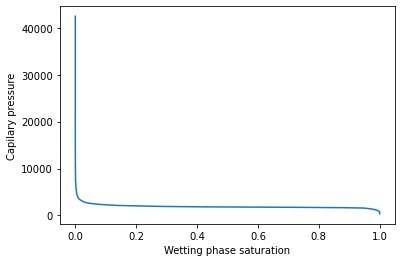

In [2]:
inlets = pn.pores('bottom')

OP_1 = op.algorithms.OrdinaryPercolation(network=pn,phase=air)
OP_1.set_inlets(pores=inlets)
OP_1.setup(phase=water, pore_volume='pore.volume', throat_volume='throat.volume')
OP_1.run(points=100)

data = OP_1.get_intrusion_data()
sw = [1-x for x in data.Snwp]
f = plt.figure()
plt.plot(sw,data.Pcap)
plt.xlabel('Wetting phase saturation')
plt.ylabel('Capilary pressure')

Text(0, 0.5, 'Capilary pressure')

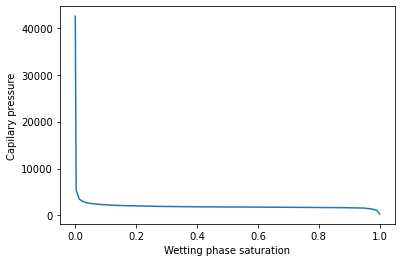

In [3]:
filter_pc = [data.Pcap[0]]
sat = [data.Snwp[0]]
for i, pc in enumerate(data.Pcap):
    if  data.Snwp[i] - sat[-1] > 0.01:
        filter_pc.append(pc)
        sat.append(data.Snwp[i])
filter_pc.append(data.Pcap[-1])
sat.append(data.Snwp[-1])
sw = [1-x for x in sat]

f = plt.figure()
plt.plot(sw,filter_pc)
plt.xlabel('Wetting phase saturation')
plt.ylabel('Capilary pressure')

In [4]:
def update_phase_and_phys(results):
    water['pore.occupancy'] = 1-results['pore.occupancy']
    air['pore.occupancy'] = results['pore.occupancy']
    water['throat.occupancy'] = 1-results['throat.occupancy']
    air['throat.occupancy'] = results['throat.occupancy']
    # Add multiphase conductances
    mode='strict'
    phys_air.add_model(model=mods.physics.multiphase.conduit_conductance,
                       propname='throat.conduit_hydraulic_conductance',
                       throat_conductance='throat.hydraulic_conductance',
                       mode=mode)
    phys_water.add_model(model=mods.physics.multiphase.conduit_conductance,
                         propname='throat.conduit_hydraulic_conductance',
                         throat_conductance='throat.hydraulic_conductance',
                         mode=mode)


update_phase_and_phys(OP_1.results(Pc=1e3))


# %% absolute permeability calculation
inlet = pn.pores('top')
outlet = pn.pores('bottom')
sf_air = op.algorithms.StokesFlow(network=pn, phase=air)
sf_air.setup(conductance='throat.hydraulic_conductance')
sf_air.set_value_BC(values=0.6, pores=inlet)
sf_air.set_value_BC(values=0.2, pores=outlet)
sf_air.run()
K_air_single_phase = sf_air.calc_effective_permeability()
proj.purge_object(obj=sf_air)


sf_water = op.algorithms.StokesFlow(network=pn, phase=water)
sf_water.setup(conductance='throat.hydraulic_conductance')
sf_water.set_value_BC(values=0.6, pores=inlet)
sf_water.set_value_BC(values=0.2, pores=outlet)
sf_water.run()
K_water_single_phase = sf_water.calc_effective_permeability()
proj.purge_object(obj=sf_water)

PyPardisoError: The Pardiso solver failed with error code -3. See Pardiso documentation for details.

In [ ]:
perm_air = []
perm_water = []

for Pc in filter_pc:
    update_phase_and_phys(OP_1.results(Pc=Pc))
    print('-'*80)
    print('Pc',Pc)

    # set up flow simulator
    sf_air = op.algorithms.StokesFlow(network=pn,phase=air)
    sf_air.setup(conductance='throat.conduit_hydraulic_conductance')
    sf_water = op.algorithms.StokesFlow(network=pn,phase=water)
    sf_water.setup(conductance='throat.conduit_hydraulic_conductance')

    # set up boundary conditions
    sf_air.set_value_BC(values=0.6, pores=inlet)
    sf_water.set_value_BC(values=0.6, pores=inlet)
    sf_air.set_value_BC(values=0.2, pores=outlet)
    sf_water.set_value_BC(values=0.2, pores=outlet)

    sf_air.run()
    sf_water.run()

    Keff_air_mphase = sf_air.calc_effective_permeability()
    Keff_water_mphase = sf_air.calc_effective_permeability()

    # cal of kr
    Kr_eff_air = Keff_air_mphase / K_air_single_phase
    Kr_eff_water = Keff_water_mphase / K_water_single_phase

    perm_air.append(Kr_eff_air)
    perm_water.append(Kr_eff_water)
    proj.purge_object(obj=sf_air)
    proj.purge_object(obj=sf_water)


In [ ]:
# plot kr curves
f = plt.figure()
plt.plot(sat,perm_air,c='b',label='air')
plt.plot(sw,perm_water,c='r',label='water')
plt.xlabel('Non wetting phase saturation')
plt.ylabel('Relative permeability')
plt.legend()